In [17]:
! pip install gekko

In [18]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from gekko import GEKKO

In [19]:
a1 = 12
a2 = 15
a3 = 33
b1 = 14
b2 = 1
b3 = 18
c1 = 1
c2 = 13
c3 = 6

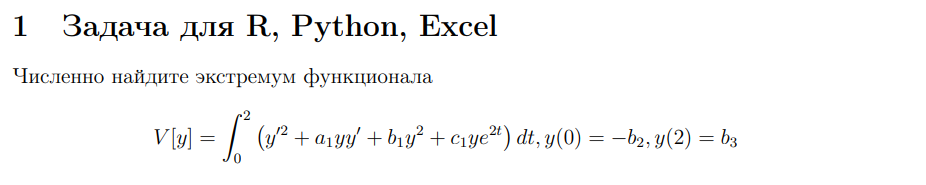


In [20]:
# генерируем значения
n = 101
t = np.linspace(0, 2, n)
dt = t[1] - t[0]

In [21]:
# это наш шаг
dt

0.02

In [22]:
# Определение функционала

def f(y):
    dy_dt = (y[1:] - y[:-1]) / dt  # задаём назад смотрящую производную
    integral = np.sum(
        (dy_dt ** 2) + a1 * y[1:] * dy_dt + b1 * (y[1:] ** 2) + c1 * y[1:] * np.exp(2 * t[1:])
    ) * dt
    return integral

# def apply_boundary_conditions(y):
#     y[0] = -b2  # y(0) = -b2
#     y[-1] = b3  # y(2) = b3
#     return y

# задаем начальные значения для y
y = np.linspace(-b2, b3, n)  # линейная интерполяция между -b2 и b3
#  = apply_boundary_conditions(y0)

# граничные условия
bounds = [(None, None) for _ in range(n)]
bounds[0], bounds[-1] = (-b2, -b2), (b3, b3)

# оптимизируем
def optimize_function(extreme_type="min"):
    if extreme_type == "min":
      multiplier = 1
    else:
      multiplier = -1

    def objective(y):
        return multiplier * f(y)

    result = minimize(objective, y, method='L-BFGS-B', bounds=bounds)
    return result, multiplier

# поиск минимума и максимума
res_min, _ = optimize_function(extreme_type="min")
res_max, multiplier_max = optimize_function(extreme_type="max")

# чекнем на успешность
print(f'Минимум: Значение функционала: {res_min.fun}, Успешность: {res_min.success}')
print(f'Максимум: Значение функционала: {multiplier_max * res_max.fun}, Успешность: {res_max.success}')

Минимум: Значение функционала: 3452.756901642175, Успешность: True
Максимум: Значение функционала: 2.9684823656085734e+23, Успешность: False


заметно, что с максимумом проблемки, скорее всего потому что функционал бесконечно возрастает

**теперь построим графики:**



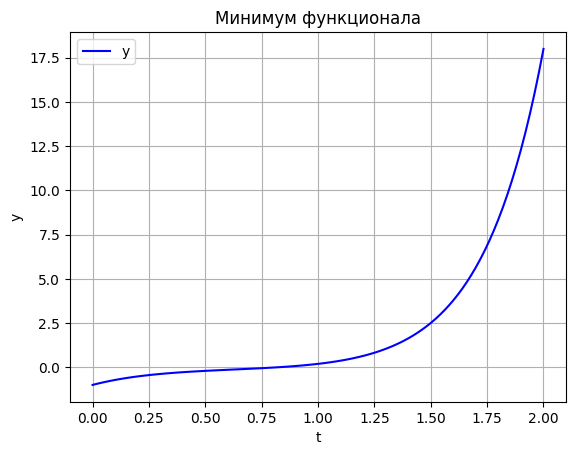

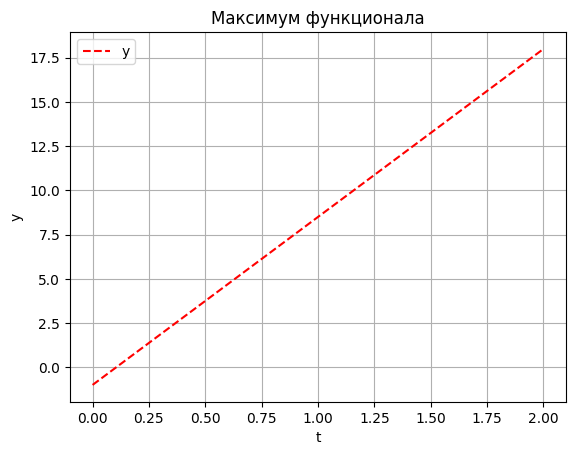

In [23]:
# для минимума
plt.figure()
plt.plot(t, res_min.x, label="y", color='b')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Минимум функционала')
plt.legend()
plt.grid()
plt.show()

# для максимума
plt.figure()
plt.plot(t, res_max.x, label="y", color='r', linestyle='--')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Максимум функционала')
plt.legend()
plt.grid()
plt.show()



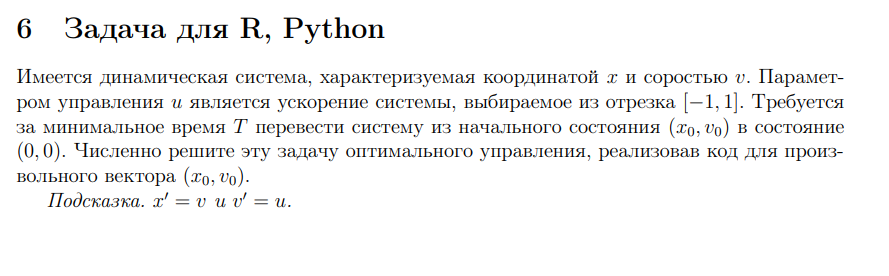

Для решения будем использовть библиотеку GEKKO

Посмотрим как будет решаться оптимизационная задача при разных начальных условиях: [10, 5]; [-5, 5]; [3,2]

In [33]:
def optimize(x0, v0, u_min, u_max, T_max):
    # задаём модель GEKKO
    m = GEKKO(remote=False)

    # генерируем время
    m.time = np.linspace(0, 1, 501)

    x = m.Var(value=x0)
    v = m.Var(value=v0)
    u = m.MV(value=0, lb=u_min, ub=u_max)
    u.STATUS = 1

    final_time = m.FV(value=1, lb=0.01)
    final_time.STATUS = T_max

    m.Equation(x.dt() == v * final_time)
    m.Equation(v.dt() == u * final_time)

    x.VALUE = x0
    v.VALUE = v0

    # конечные условия
    m.Obj(final_time)
    m.fix(x, pos=len(m.time)-1, val=0)
    m.fix(v, pos=len(m.time)-1, val=0)

    # решаем оптимизационную задачу
    m.options.IMODE = 6
    m.solve(disp=False)

    optimal_time = final_time.value[0]
    print(f'Оптимальное время: {optimal_time:.4f}')

    # Построение графиков
    plt.figure(figsize=(10, 6))
    plt.plot(m.time * optimal_time, x.VALUE, label='Позиция x', linestyle='-', linewidth=2)
    plt.plot(m.time * optimal_time, v.VALUE, label='Скорость v', linestyle='-', linewidth=2)
    plt.step(m.time * optimal_time, u.VALUE, label='Управление u', where='post', linestyle='-', linewidth=2)

    plt.title('Решение задачи оптимального управления', fontsize=16, fontweight='bold')
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Значения', fontsize=14)
    plt.legend(fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


**теперь построим графики:**

Зададим начальное положение x0: 3
Зададим начальную скорость v0: 2
Оптимальное время: 6.4793


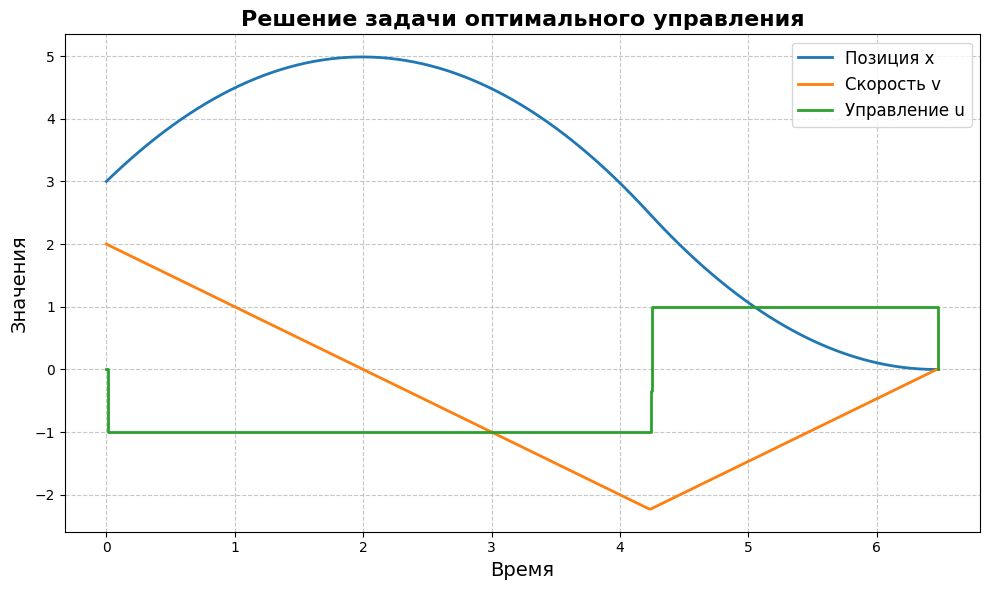

In [40]:
# начальные условия
u_min = -1
u_max = 1
T_max = 1

x0 = float(input('Зададим начальное положение x0: '))
v0 = float(input('Зададим начальную скорость v0: '))

optimize(x0, v0, u_min, u_max, T_max)

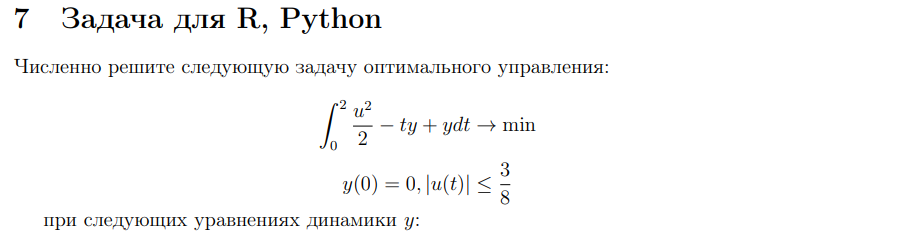

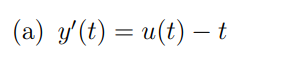

In [43]:
m = GEKKO(remote=False)
m.time = np.linspace(0, 2, 101)

# задаём переменные
y = m.Var(value=0)
u = m.Var(value=0, lb=-3/8, ub=3/8)
t = m.Var(value=0)
z = m.Var(value=0)             # интеграл целевой функции

p = np.zeros(101)
p[-1] = 1.0
final = m.Param(value=p)

m.Equation(y.dt() == u - t)
m.Equation(t.dt() == 1)
m.Equation(z.dt() == u**2 / 2 - t * y + y)

m.Obj(z * final)
m.options.IMODE = 6  # всё та же динамическая оптимизация
m.solve(disp=False)

time = m.time
y_res = y.VALUE
u_res = u.VALUE
z_res = z.VALUE

print(f"Оптимальное значение целевой функции z: {z_res[-1]}")

Оптимальное значение целевой функции z: 0.55858866399


**теперь построим графики:**

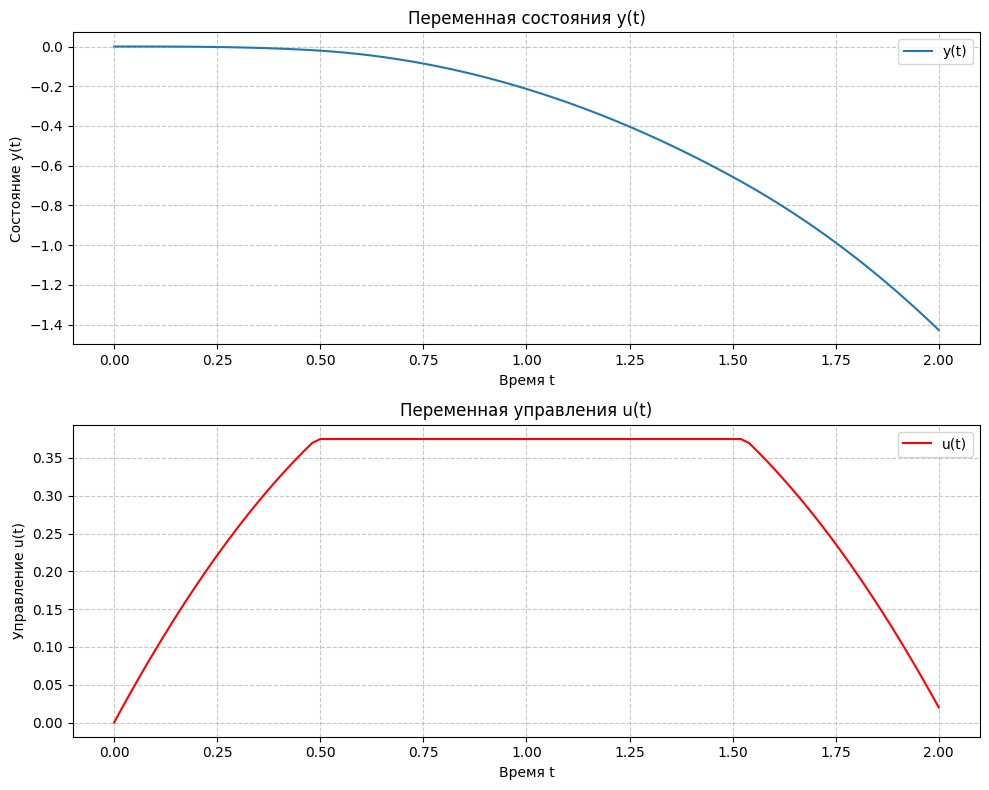

In [42]:
plt.figure(figsize=(10, 8))

# График состояния y(t)
plt.subplot(2, 1, 1)
plt.plot(time, y_res, label='y(t)')
plt.xlabel('Время t')
plt.ylabel('Состояние y(t)')
plt.title('Переменная состояния y(t)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# График управления u(t)
plt.subplot(2, 1, 2)
plt.plot(time, u_res, label='u(t)', color='red')
plt.xlabel('Время t')
plt.ylabel('Управление u(t)')
plt.title('Переменная управления u(t)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


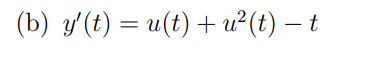

In [44]:
m = GEKKO(remote=False)
m.time = np.linspace(0, 2, 101)

# задаём переменные
y = m.Var(value=0)
u = m.Var(value=0, lb=-3/8, ub=3/8)
t = m.Var(value=0)
z = m.Var(value=0)              # интеграл целевой функции

p = np.zeros(101)
p[-1] = 1.0
final = m.Param(value=p)

m.Equation(y.dt() == u + u**2 - t)
m.Equation(t.dt() == 1)
m.Equation(z.dt() == u**2 / 2 - t * y + y)

m.Obj(z * final)
m.options.IMODE = 6  # всё та же динамическая оптимизация
m.solve(disp=False)

time = m.time
y_res = y.VALUE
u_res = u.VALUE
z_res = z.VALUE

print(f"Оптимальное значение целевой функции z: {z_res[-1]}")


Оптимальное значение целевой функции z: 0.46954566657


**теперь построим графики:**

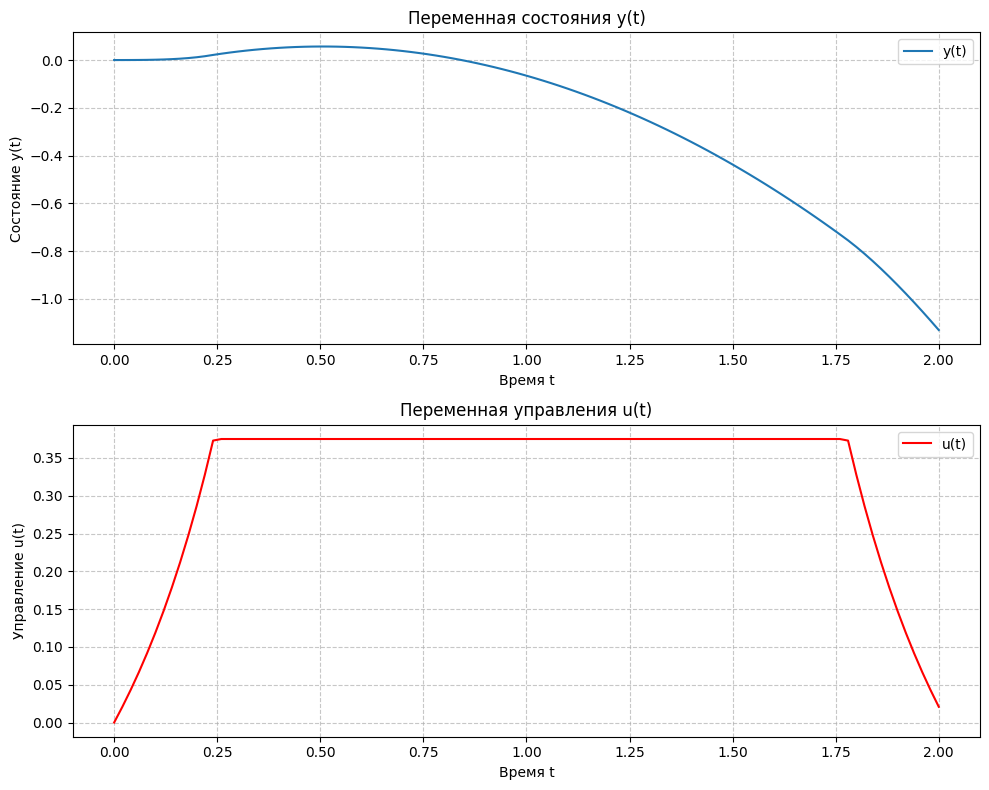

In [45]:
plt.figure(figsize=(10, 8))

# График состояния y(t)
plt.subplot(2, 1, 1)
plt.plot(time, y_res, label='y(t)')
plt.xlabel('Время t')
plt.ylabel('Состояние y(t)')
plt.title('Переменная состояния y(t)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# График управления u(t)
plt.subplot(2, 1, 2)
plt.plot(time, u_res, label='u(t)', color='red')
plt.xlabel('Время t')
plt.ylabel('Управление u(t)')
plt.title('Переменная управления u(t)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

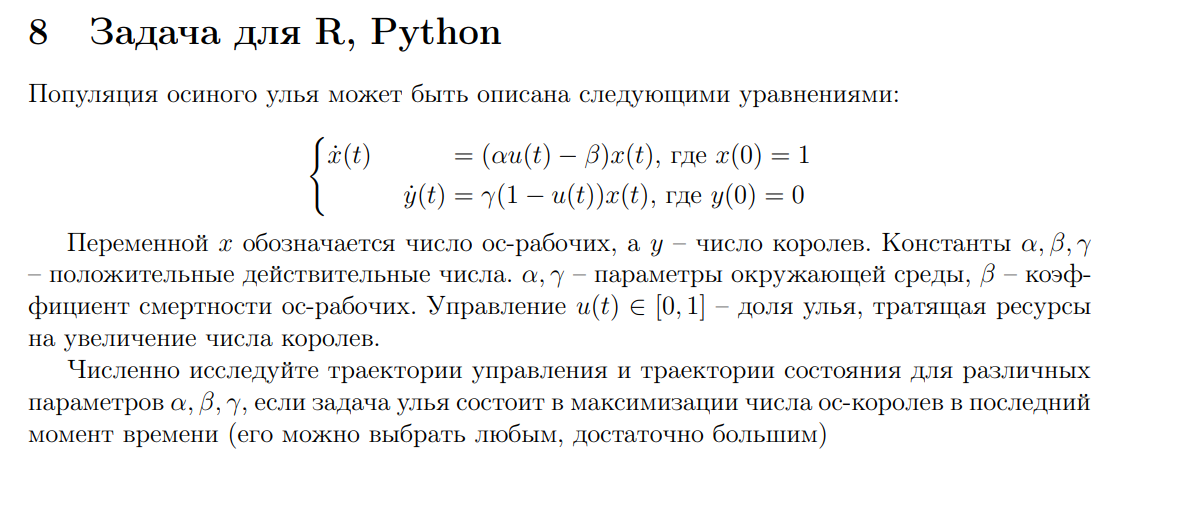

In [30]:
def wasp_population(alpha, beta, gamma, T=100, nt=101):
    m = GEKKO(remote=False)
    m.time = np.linspace(0, T, nt)

    x = m.Var(value=1, name='x')
    y = m.Var(value=0, name='y')
    u = m.Var(value=0.5, lb=0, ub=1, name='u')

    m.Equation(x.dt() == (alpha * u - beta) * x)
    m.Equation(y.dt() == gamma * (1 - u) * x)

    p = np.zeros(nt)
    p[-1] = 1.0
    final = m.Param(value=p)
    m.Obj(-y * final)

    m.options.IMODE = 6
    m.solve(disp=False)

    return m.time, x.value, y.value, u.value

In [31]:
def plots(time, x, y, u, alpha, beta, gamma, i):
    plt.figure(figsize=(12, 6))

    # график рабочих ос и королев
    plt.subplot(1, 2, 1)
    plt.plot(time, x, 'b-', label='Число рабочих ос $x(t)$')
    plt.plot(time, y, 'r-', label='Число королев $y(t)$')
    plt.plot(time, u, 'g-', label='Оптимальное управление $u(t)$')
    plt.xlabel('Время')
    plt.ylabel('Численность')
    plt.title(f'График {i}: α={alpha}, β={beta}, γ={gamma}')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


**теперь построим графики:**

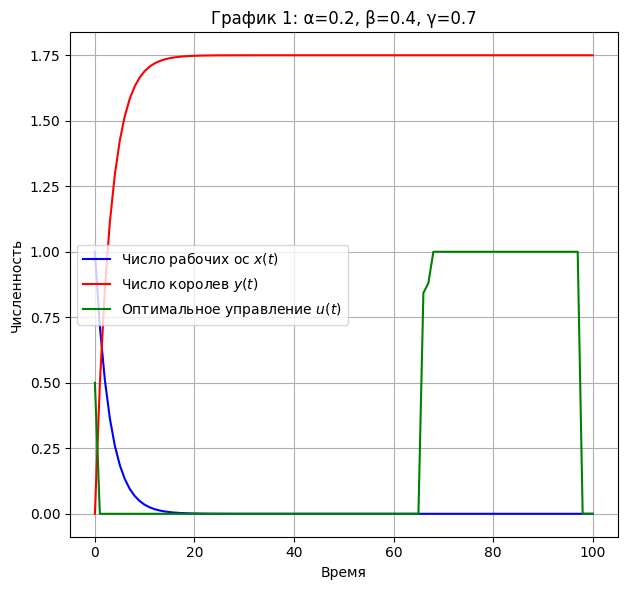

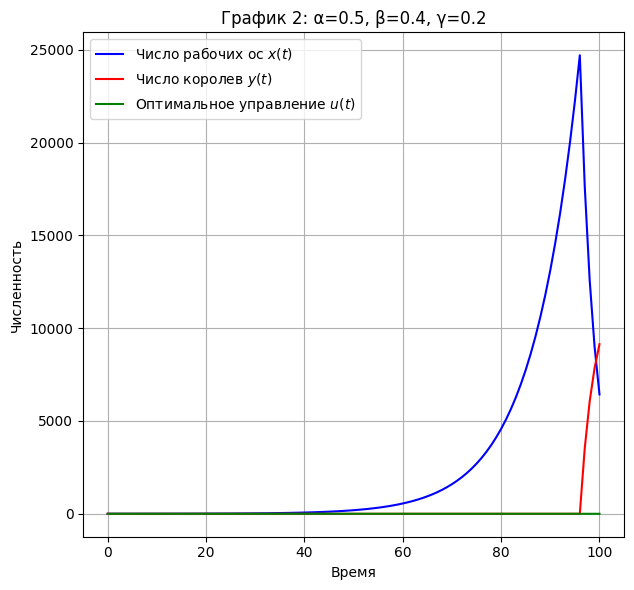

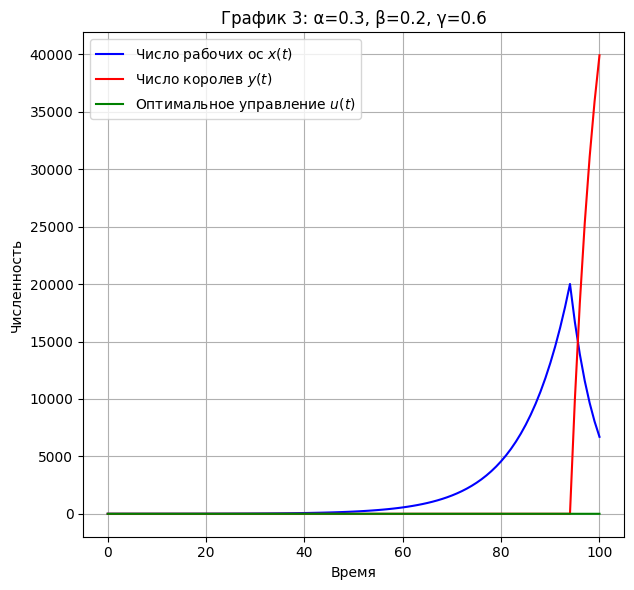

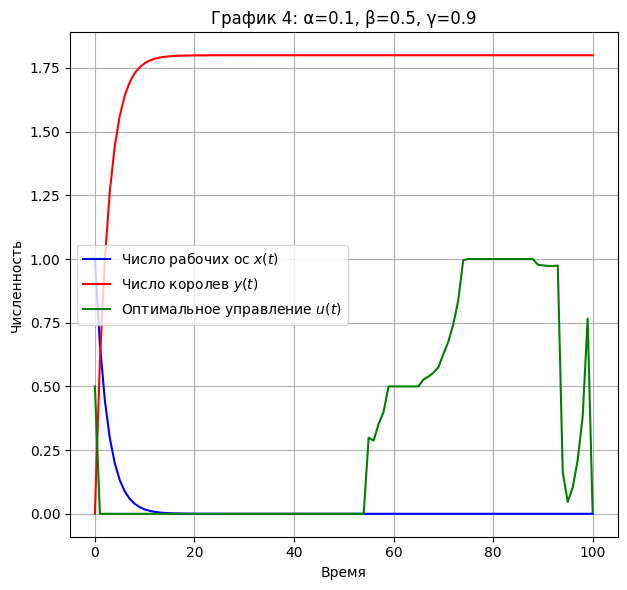

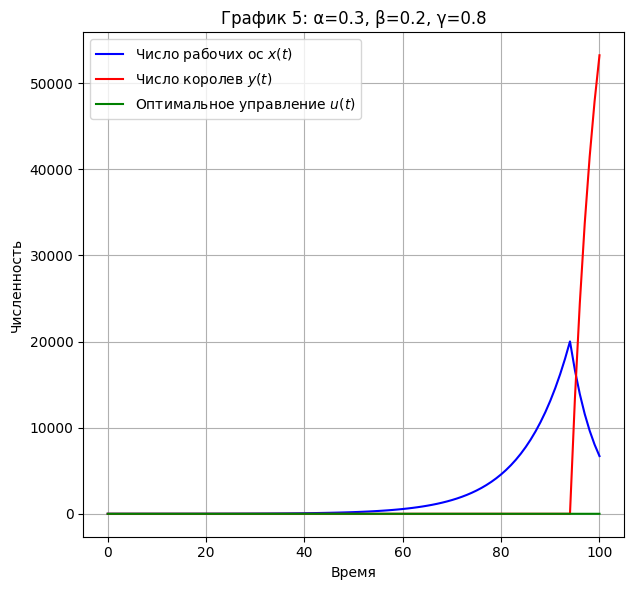

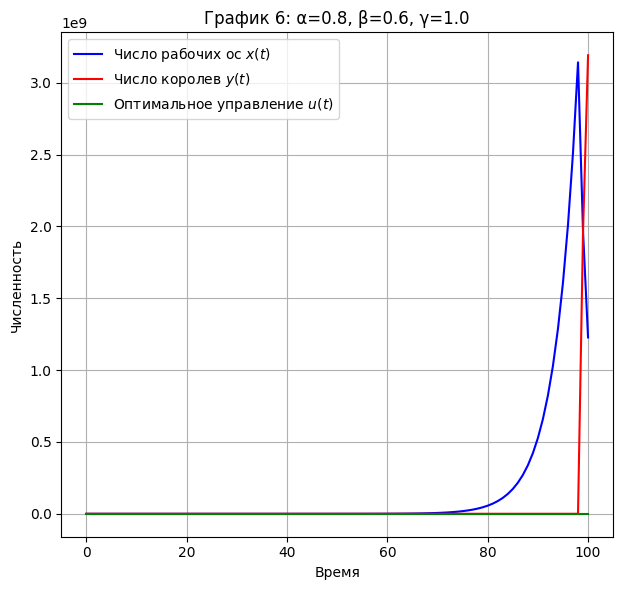

In [48]:
param_sets = [
    (0.2, 0.4, 0.7),
    (0.5, 0.4, 0.2),
    (0.3, 0.2, 0.6),
    (0.1, 0.5, 0.9),
    (0.3, 0.2, 0.8),
    (0.8, 0.6, 1.0),
]

# строим графики
for i, (alpha, beta, gamma) in enumerate(param_sets, 1):
    time, x, y, u = wasp_population(alpha, beta, gamma)
    plots(time, x, y, u, alpha, beta, gamma, i)